# Accessing DEMs from the Planetary Computer catalogs

This code is based on the Documentation of the Microsoft ***Planetary Computer*** platform:

[Reading Data from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/)

The Digital Terrain Models are taken from the platform [Planetary Computer](https://planetarycomputer.microsoft.com/explore)

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pystac
import planetary_computer
import rioxarray
import numpy as np

%matplotlib inline

In [2]:
import sys
import importlib
sys.path.append('../../modules')
from plotting import raster_plotting
importlib.reload(raster_plotting);

In [3]:
from matplotlib.colors import LinearSegmentedColormap
cmap_terrain = plt.get_cmap('terrain')

cmap_terrain_crust = LinearSegmentedColormap.from_list(
    'terrain_crust', cmap_terrain(np.linspace(0.25, 1, 256))
)
cmap_terrain_crust.set_bad(color='blue')

## Accessing an individual item's data assets.

In [4]:
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/cop-dem-glo-30/items/Copernicus_DSM_COG_10_N06_00_W077_00_DEM"
# item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/cop-dem-glo-30/items/Copernicus_DSM_COG_10_N06_00_W078_00_DEM"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)

signed_item = planetary_computer.sign(item)

# Open one of the data assets 
asset_href = signed_item.assets["data"].href
ds = rioxarray.open_rasterio(asset_href)
ds;

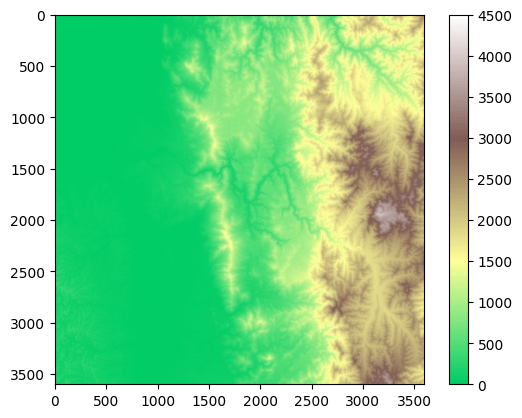

In [5]:
plt.figure()
plt.imshow(ds[0, ...], cmap=cmap_terrain_crust, vmin=0, vmax=4500)
plt.colorbar()
plt.show()

## Combining two individual item's data assets.

In [6]:
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/cop-dem-glo-30/items/Copernicus_DSM_COG_10_N06_00_W078_00_DEM"
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)
asset_href = signed_item.assets["data"].href
ds2 = rioxarray.open_rasterio(asset_href)

# Ensure both datasets have CRS information
ds_crs = ds.rio.write_crs("EPSG:4326", inplace=False)
ds2_crs = ds2.rio.write_crs("EPSG:4326", inplace=False)

combined_ds = xr.combine_by_coords([ds_crs, ds2_crs])
combined_ds;

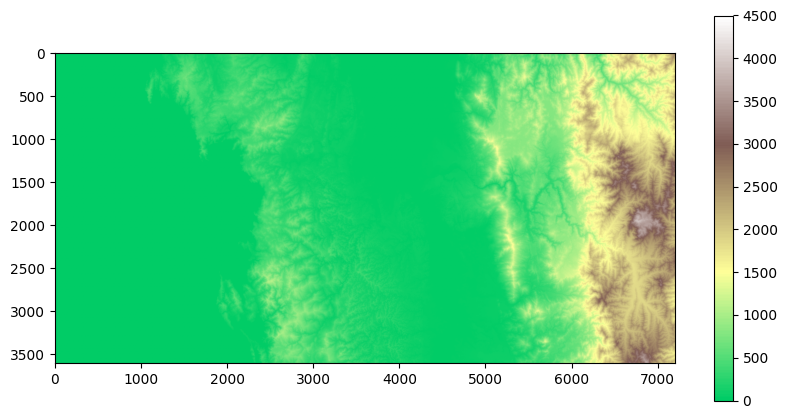

In [7]:
plt.figure(figsize=(10, 5))
plt.imshow(combined_ds[0, ...], cmap=cmap_terrain_crust, vmin=0, vmax=4500)
plt.colorbar()
plt.show()

## Accessing multiple item's data assets.

In [8]:
from pystac_client import Client
import planetary_computer as pc

# Search against the Planetary Computer STAC API
catalog = Client.open(
  "https://planetarycomputer.microsoft.com/api/stac/v1",
  modifier=planetary_computer.sign_inplace,
)

# Define your area of interest
aoi = {
  "type": "Polygon",
  "coordinates": [
    [
      [-78, 5],
      [-76.5, 5],
      [-76.5, 8.5],
      [-78, 8.5],
      [-78, 5]
    ]
  ]
}

# Define your temporal range
daterange = {"timestamp": "2021-04-22"}

# Define your search with CQL2 syntax
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
    {"op": "=", "args": [{"property": "datetime"}, daterange]},
    {"op": "=", "args": [{"property": "collection"}, "cop-dem-glo-30"]}
  ]
})
items = search.item_collection()
print("Number of items found:", len(items))

Number of items found: 10


In [9]:
d1 = rioxarray.open_rasterio(items[0].assets["data"].href)
d1;

In [10]:
dem_arrays = []

for i, item in enumerate(items):
    print(f"Loading item {i+1}/{len(items)}: {item.id}")
    
    # open the DEM tile
    dem_tile = rioxarray.open_rasterio(item.assets["data"].href)
    
    # CRS information
    dem_tile_crs = dem_tile.rio.write_crs("EPSG:4326", inplace=False)
    
    # append to list
    dem_arrays.append(dem_tile_crs)

print(f"Loaded {len(dem_arrays)} DEM tiles")

Loading item 1/10: Copernicus_DSM_COG_10_N08_00_W078_00_DEM
Loading item 2/10: Copernicus_DSM_COG_10_N08_00_W077_00_DEM
Loading item 3/10: Copernicus_DSM_COG_10_N07_00_W078_00_DEM
Loading item 4/10: Copernicus_DSM_COG_10_N07_00_W077_00_DEM
Loading item 5/10: Copernicus_DSM_COG_10_N06_00_W078_00_DEM
Loading item 6/10: Copernicus_DSM_COG_10_N06_00_W077_00_DEM
Loading item 7/10: Copernicus_DSM_COG_10_N05_00_W078_00_DEM
Loading item 8/10: Copernicus_DSM_COG_10_N05_00_W077_00_DEM
Loading item 9/10: Copernicus_DSM_COG_10_N04_00_W078_00_DEM
Loading item 10/10: Copernicus_DSM_COG_10_N04_00_W077_00_DEM
Loaded 10 DEM tiles


In [17]:
# Combine all DEM tiles into a single xarray DataArray
print("Combining DEM tiles...")
combined_dem = xr.combine_by_coords(dem_arrays)
print(f"Combined DEM shape: {combined_dem.shape}")
print(f"Combined DEM bounds: x({combined_dem.x.values.min():.4f}, {combined_dem.x.values.max():.4f}), y({combined_dem.y.values.min():.4f}, {combined_dem.y.values.max():.4f})")
combined_dem;

Combining DEM tiles...
Combined DEM shape: (1, 18000, 7200)
Combined DEM bounds: x(-78.0000, -76.0003), y(4.0003, 9.0000)


In [12]:
# # save to GeoTIFF (compatible with GIS software)
# combined_dem.rio.to_raster('../../data/DEM/combined_dem_pacifico.tif')
# print("DEM saved as combined_dem_pacifico.tif")

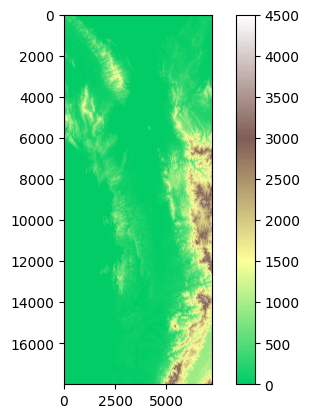

In [18]:
plt.figure()
plt.imshow(combined_dem[0, ...], cmap=cmap_terrain_crust, vmin=0, vmax=4500)
plt.colorbar()
plt.show()

## Reading Saved DEM

In [14]:
filename = '../../data/DEM/combined_dem_pacifico.tif' # DTM taken from planetarycomputer.microsoft.com
topography = xr.load_dataset(filename, engine="rasterio")
topography;

In [15]:
sampling = 10
topography_subsampled = topography.isel(
    x=slice(None, None, sampling),
    y=slice(None, None, sampling)
)
topography_subsampled;

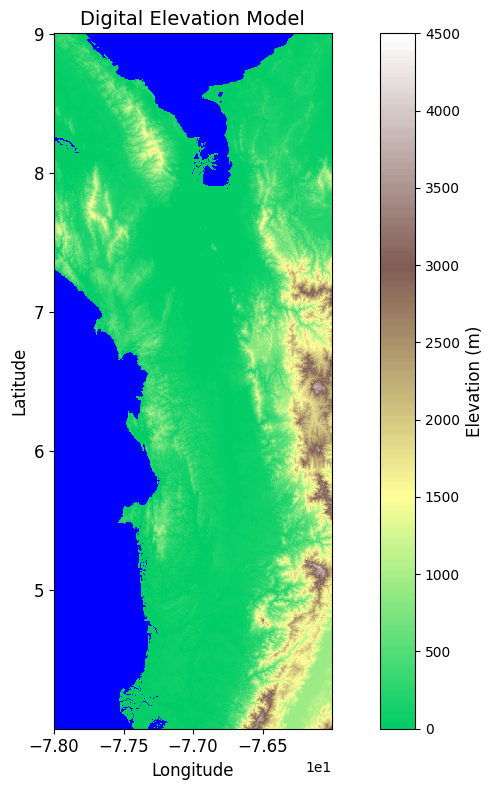

In [16]:
raster_plotting.plot_raster_data(topography_subsampled.x, topography_subsampled.y, topography_subsampled.band_data[0], data_type='DEM')